# Example of full DALL-E training and usage
### We generate a synthetic dataset with ~9000 geometric shapes rendered as 32x32 pictures, and their descriptions
E.g.: small orange circle
### DALL-E's task is to generate the image from its description
### We test its generalization capability by training it on 30% of data and checking its generated images for unseen descriptions

In [1]:
# check whether colab instance has GPU hardwear
!nvidia-smi

Thu Nov 25 06:09:26 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    25W / 300W |      0MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# install dalle-pytorch and restart the instance if necessary
!pip install dalle-pytorch --upgrade

In [ ]:
!apt install libcairo2-dev
!pip install pycairo

In [2]:
%load_ext autoreload
%autoreload 2

In [5]:
import math
import itertools
import os
import glob

import numpy as np
import cairo
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
%config InlineBackend.figure_format = 'retina'
from PIL import Image
from tqdm.autonotebook import tqdm, trange
import torch
from dalle_pytorch import DiscreteVAE, DALLE

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  del sys.path[0]


# Dataset generation

In [8]:
rainbow_colors = ["red", "orange", "yellow", "green", "blue", "indigo", "violet"]
rainbow_rgb = [np.array(mcolors.to_rgb(name)) * 255 for name in rainbow_colors]

def make_pic(size, shape_maker, color_name, scale, fill, ditherer, rotation):
    data = np.ones((size, size, 4), dtype=np.uint8)
    surface = cairo.ImageSurface.create_for_data(data, cairo.FORMAT_ARGB32, size, size)
    cr = cairo.Context(surface)
    cr.set_antialias(cairo.ANTIALIAS_NONE)
    cr.set_fill_rule(cairo.FILL_RULE_EVEN_ODD)
    
    cr.rectangle(0, 0, size, size)
    cr.set_source_rgb(1, 1, 1)
    cr.fill()
    cr.set_line_width(1 / (scale * size / 2))
    
    cr.translate(size // 2, size // 2)
    cr.scale(scale * size / 2, scale * size / 2)
    if color_name == "rainbow":
        cr.set_source_rgb(0, 0, 0)
    else:
        cr.set_source_rgb(*reversed(mcolors.to_rgb(color_name)))
        
    shape_maker(cr)
    if fill:
        cr.stroke_preserve()
        cr.fill()    
    else:
        cr.stroke()
        
    for _ in range(rotation):
        data = np.rot90(data)
        
    ditherer(data)
    
    if color_name == "rainbow":
        mask = data.sum(axis=2) != 255 * 4
        for r in range(size):
            data[r, mask[r, :], :3] = rainbow_rgb[r % len(rainbow_colors)]
        
    return data


Total shapes: 9216


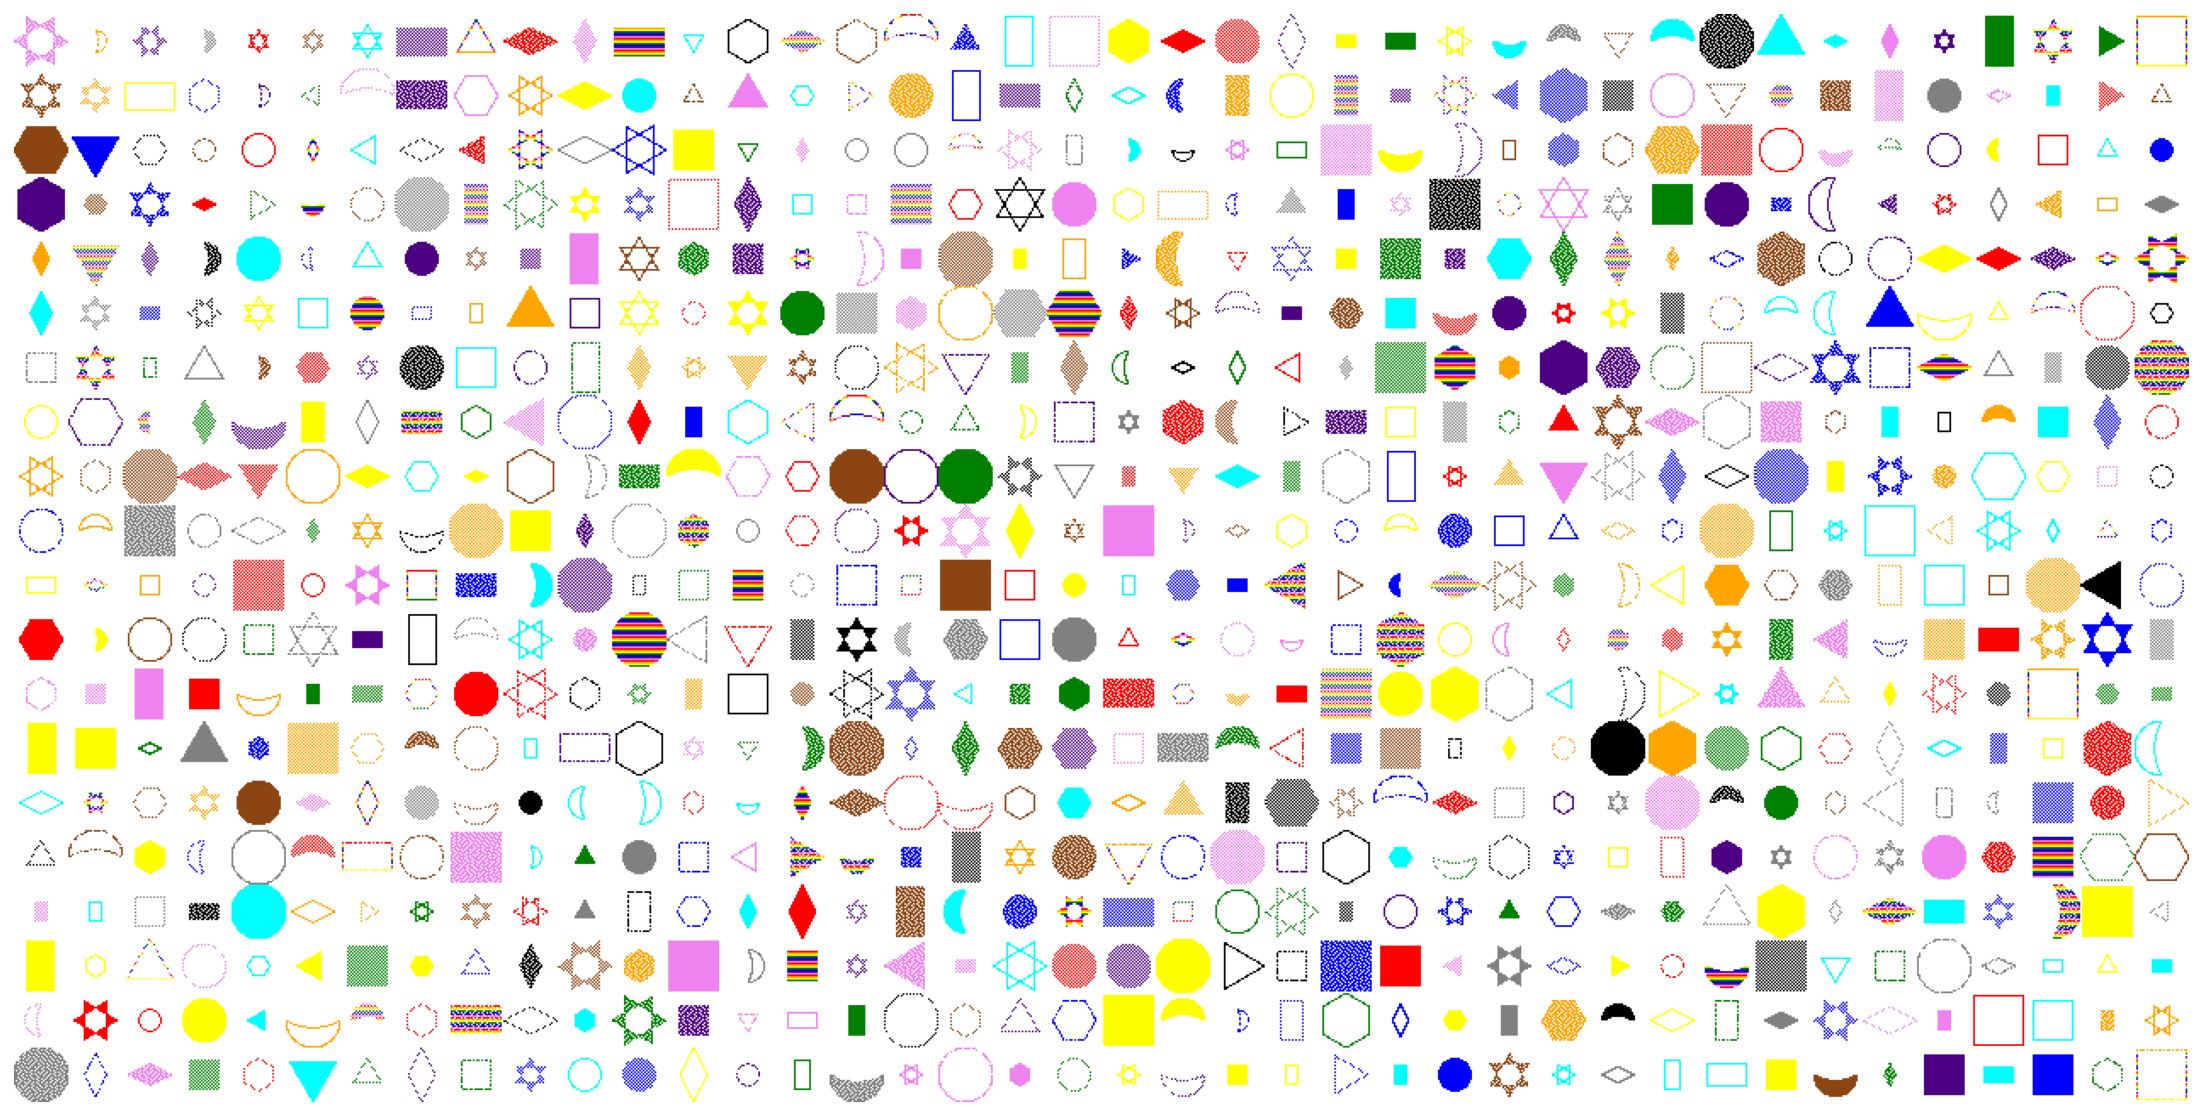

In [9]:
def circle_maker(cr):
    cr.arc(0, 0, 1, 0, 2 * math.pi)
    
    
def triangle_maker(cr):
    s3 = math.sqrt(3)
    cr.move_to(0, -1)
    cr.line_to(s3 / 2, 0.5)
    cr.line_to(-s3 / 2, 0.5)
    cr.line_to(0, -1)
    
    
def square_maker(cr):
    cr.rectangle(-0.9, -0.9, 1.8, 1.8)
    
def rectangle_maker(cr):
    cr.rectangle(-0.9, -0.5, 1.8, 1)    
    
def rhombus_maker(cr):
    cr.move_to(0, -1)
    cr.line_to(0.5, 0)
    cr.line_to(0, 1)
    cr.line_to(-0.5, 0)
    cr.line_to(0, -1)
    
    
def star_maker(cr):
    s3 = math.sqrt(3)
    cr.move_to(0, -1)
    cr.line_to(s3 / 2, 0.5)
    cr.line_to(-s3 / 2, 0.5)
    cr.line_to(0, -1)
    
    cr.move_to(0, 1)
    cr.line_to(s3 / 2, -0.5)
    cr.line_to(-s3 / 2, -0.5)
    cr.line_to(0, 1)
    
    
def hexagon_maker(cr):
    s3 = math.sqrt(3)
    cr.move_to(0, -1)
    cr.line_to(s3 / 2, -0.5)    
    cr.line_to(s3 / 2, 0.5)
    cr.line_to(0, 1)        
    cr.line_to(-s3 / 2, 0.5)
    cr.line_to(-s3 / 2, -0.5)    
    cr.line_to(0, -1)
    
    
def crescent_maker(cr):
    s3 = math.sqrt(3)    
    cr.arc(0, 0, 1, -math.pi * 0.5, math.pi * 0.5)
    cr.move_to(0, -1)
    cr.arc(-s3, 0, 2, -math.pi / 6, math.pi / 6)
   
    
def dither_solid(data):
    pass


def dither(img):
    for y in range(0, img.shape[0] - 1):
        for x in range(1, img.shape[1] - 1):
            pix = img[y][x]
            newpix = round(pix)

            error = pix - newpix

            img[y][x] = newpix

            img[y    , x + 1] += error * 7/16
            img[y + 1, x - 1] += error * 3/16
            img[y + 1, x    ] += error * 5/16
            img[y + 1, x + 1] += error * 1/16

def dither_halftone(data):
    mask = (data.astype(int).sum(axis=2) != 255 * 3).astype(float)
    mask *= 0.5
    dither(mask)
    data[mask > 0.5, :] = 255
        
def dither_shaded(data):
    mask = (data.astype(int).sum(axis=2) != 255 * 3).astype(float)
    mask *= 0.3
    dither(mask)
    data[mask > 0.5, :] = 255        

    
variations = {
    "scale": {"big": 1, "bigger": 0.8, "smaller": 0.6, "small": 0.4},
    "fill": {"filled": True, "": False},
    "ditherer": {"": dither_solid, "shaded": dither_shaded, "halftone": dither_halftone},
    "color_name": {c: c for c in rainbow_colors + ["cyan", "saddlebrown", "black", "gray", "rainbow"]},
    "shape_maker": {"circle": circle_maker, "triangle": triangle_maker, "square": square_maker, "rhombus": rhombus_maker, "rectangle": rectangle_maker, "star": star_maker, "hexagon": hexagon_maker,
              "crescent": crescent_maker},
    "rotation": {"": 0, "rotated clockwise": 1, "rotated twice": 2, "rotated counterclockwise": 3},
}
    
        
print(f"Total shapes: {np.prod([len(v) for v in variations.values()])}")
        
    
pics = []
for _ in range(20):
    row = []
    for _ in range(40):
        params = {name: np.random.choice(list(values.values())) for name, values in variations.items()}
        row.append(make_pic(32, **params)[:, :, :3])
        
    pics.append(np.concatenate(row, axis=1))
    
pics = np.concatenate(pics)
# write output
plt.figure(figsize=(20, 10))
plt.axis("off")
plt.imshow(pics)

In [10]:
all_variations = list(itertools.product(*[v.items() for v in variations.values()]))
if not os.path.exists("data"):
    os.mkdir("data")

if not os.path.exists("data/rainbow"):
    os.mkdir("data/rainbow")
    for vars in tqdm(all_variations):
        name = " ".join(n for n, v in vars if n != "").replace(" ", "_")
        params = dict(zip(variations, [v for n, v in vars]))
        pic = make_pic(32, **params)[:, :, :3]
        im = Image.fromarray(pic)
        im.save(f"data/rainbow/{name}.png")

  0%|          | 0/9216 [00:00<?, ?it/s]

# Training VAE

In [13]:
import torch
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

device(type='cuda', index=0)

In [14]:
captions = []
images = []
for fn in glob.glob("data/rainbow/*.png"):
    captions.append(os.path.basename(fn).replace(".png", "").split("_"))    
    im = np.array(Image.open(fn))
    images.append(im)
    
images = np.stack(images).astype(float) / 255
images = torch.from_numpy(images).to(torch.float32).permute(0, 3, 1, 2).to(device)

(-0.5, 319.5, 31.5, -0.5)

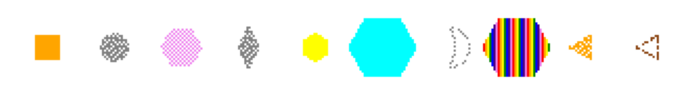

In [15]:
plt.imshow(images[np.random.choice(images.shape[0], 10), ...].cpu().permute(0, 2, 3, 1).reshape(320, 32, 3).permute(1, 0, 2).numpy())
plt.axis("off")

In [16]:
def fit(model, opt, criterion, scheduler, train_x, train_y, epochs, batch_size,
        model_file, trainer, n_train_samples=None):
    epoch_loss_train = []

    if n_train_samples is None:
        n_train_samples = train_x.shape[0]

    t = trange(epochs)
    for _ in t:
        rnd_idx = list(range(n_train_samples))
        np.random.shuffle(rnd_idx)
        losses = []
        for batch_idx in range(0, n_train_samples, batch_size):
            model.train()
            opt.zero_grad()
            loss = trainer(model, train_x, train_y, rnd_idx[batch_idx:(batch_idx + batch_size)], criterion)
            loss.backward()
            losses.append(loss.item())
            opt.step()

        epoch_loss_train.append(np.mean(losses))
        scheduler.step()

        t.set_description(f"train: {epoch_loss_train[-1]:.3f}")

    torch.save(model.state_dict(), model_file)
    model.eval()
    return model, epoch_loss_train

In [17]:
vae = DiscreteVAE(
    image_size = images.shape[2],
    num_layers = 3,          # number of downsamples - ex. 256 / (2 ** 3) = (32 x 32 feature map)
    num_tokens = 256,       # number of visual tokens. in the paper, they used 8192, but could be smaller for downsized projects
    codebook_dim = 512,      # codebook dimension
    hidden_dim = 64,         # hidden dimension
    num_resnet_blocks = 2,   # number of resnet blocks
    temperature = 0.9,       # gumbel softmax temperature, the lower this is, the harder the discretization
    straight_through = False # straight-through for gumbel softmax. unclear if it is better one way or the other
).to(device)

opt = torch.optim.Adam(vae.parameters(), lr=0.001, weight_decay=0.0)
scheduler = torch.optim.lr_scheduler.ExponentialLR(opt, 0.99)

In [18]:
def train_vae_batch(vae, images, _, idx, __):
    loss = vae(images[idx, ...], return_loss = True)
    return loss

In [19]:
vae_model_file = "data/rainbow_vae.model"
if not os.path.exists(vae_model_file):
    vae, loss_history = fit(vae, opt, None, scheduler, images, None, 500, 128, vae_model_file, train_vae_batch)
    plt.plot(loss_history)
else:
    vae.load_state_dict(torch.load(vae_model_file))

In [20]:
with torch.no_grad():
    all_image_codes = vae.get_codebook_indices(images)
    all_images_decoded = vae.decode(all_image_codes)
    
all_image_codes[np.random.choice(images.shape[0], 10), ...]

tensor([[ 85,  62,  62,  85, 119, 189, 189, 119, 119, 119, 119, 119, 202, 202,
         202, 202],
        [202, 202, 202,  82,  85, 125, 125,  82, 202, 224, 224, 202,  85,  62,
          62,  82],
        [202,  62, 202, 202,  26,  60, 166, 126,  60, 146, 194, 202,  85,  62,
          62,  82],
        [215,  60, 194,  26,  60,  62, 202, 215, 194, 202,  62, 194, 189, 215,
          58,  60],
        [202,  82,  62, 202,  33,  60, 130,  33,  60, 126,  59,  60,  62,  62,
         202,  62],
        [202,  62, 202, 202,  26,  60, 130, 126,  60, 139, 139, 202,  85,  62,
          62,  82],
        [202,  62, 202,  82, 202, 157, 157,  62,  62, 157, 157,  62,  82,  85,
          62,  82],
        [ 62,  82, 126, 202,  85, 139, 139, 131, 189, 139, 139, 202,  62, 131,
         202,  82],
        [202,  85,  60,  62,  62, 201, 201,  62, 202, 201, 201,  62,  62, 189,
         202,  82],
        [202,  62, 202, 202,  62, 221, 146, 202, 202, 146, 148,  62,  85,  62,
          62,  82]], device='c

## Random reconstructions
Top: original pictures

Bottom: VAE reconstructions

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(-0.5, 319.5, 63.5, -0.5)

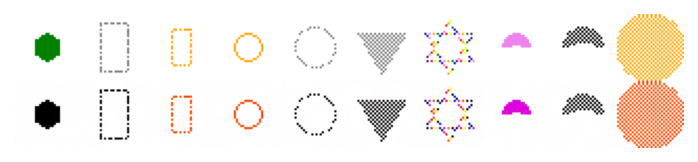

In [21]:
idx = np.random.choice(images.shape[0], 10)
orig_pics = images[idx, ...].cpu().permute(0, 2, 3, 1).reshape(320, 32, 3).permute(1, 0, 2).numpy()
decoded_pics = all_images_decoded[idx, ...].cpu().permute(0, 2, 3, 1).reshape(320, 32, 3).permute(1, 0, 2).numpy()
both = np.concatenate((orig_pics, decoded_pics), axis=0)
plt.imshow(both)
plt.axis("off")

## Worst reconstructions
They look very similar, meaning that VAE is trained well

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


big filled black square rotated clockwise; big filled black square; big filled black square rotated twice; big filled black square rotated counterclockwise; big filled black circle; big filled black circle rotated counterclockwise; big filled black circle rotated twice; big filled black circle rotated clockwise; big filled green square rotated clockwise; big filled green square rotated counterclockwise


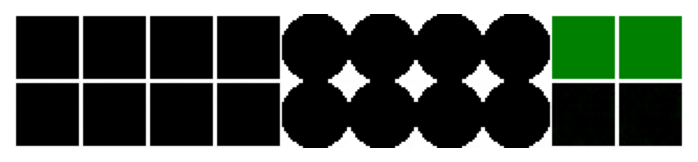

In [22]:
diffs = (images - all_images_decoded).abs().sum(axis=(1, 2, 3)).cpu().numpy()
most_different = np.argsort(-diffs)
idx = most_different[:10]
orig_pics = images[idx, ...].cpu().permute(0, 2, 3, 1).reshape(320, 32, 3).permute(1, 0, 2).numpy()
decoded_pics = all_images_decoded[idx, ...].cpu().permute(0, 2, 3, 1).reshape(320, 32, 3).permute(1, 0, 2).numpy()
both = np.concatenate((orig_pics, decoded_pics), axis=0)
plt.imshow(both)
plt.axis("off")
print("; ".join(' '.join(captions[i]) for i in idx))

# Training DALL-E
We randomly split data into 30% training set and 70% test set

In [23]:
print(captions[:10])

[['smaller', 'shaded', 'green', 'square', 'rotated', 'clockwise'],
 ['small', 'filled', 'shaded', 'gray', 'rectangle', 'rotated', 'clockwise'],
 ['big', 'filled', 'halftone', 'orange', 'crescent', 'rotated', 'clockwise'],
 ['small', 'filled', 'shaded', 'yellow', 'crescent', 'rotated', 'clockwise'],
 ['big', 'cyan', 'hexagon', 'rotated', 'clockwise'],
 ['smaller', 'filled', 'yellow', 'hexagon'],
 ['small', 'shaded', 'indigo', 'square', 'rotated', 'twice'],
 ['big', 'shaded', 'blue', 'rectangle', 'rotated', 'counterclockwise'],
 ['small', 'shaded', 'green', 'rhombus', 'rotated', 'twice'],
 ['bigger', 'halftone', 'cyan', 'hexagon']]

In [24]:
import itertools

all_words = list(sorted(frozenset(list(itertools.chain.from_iterable(captions)))))
word_tokens = dict(zip(all_words, range(1, len(all_words) + 1)))
caption_tokens = [[word_tokens[w] for w in c] for c in captions]

In [25]:
caption_tokens[-1]

[2, 13, 19, 5, 21, 7]

In [26]:
longest_caption = max(len(c) for c in captions)
captions_array = np.zeros((len(caption_tokens), longest_caption), dtype=np.int64)
for i in range(len(caption_tokens)):
    captions_array[i, :len(caption_tokens[i])] = caption_tokens[i]
    
captions_array = torch.from_numpy(captions_array).to(device)
captions_mask = captions_array != 0

In [27]:
dalle = DALLE(
    dim = 1024,
    vae = vae,                  # automatically infer (1) image sequence length and (2) number of image tokens
    num_text_tokens = len(word_tokens) + 1,    # vocab size for text
    text_seq_len = longest_caption,         # text sequence length
    depth = 12,                 # should aim to be 64
    heads = 16,                 # attention heads
    dim_head = 64,              # attention head dimension
    attn_dropout = 0.1,         # attention dropout
    ff_dropout = 0.1            # feedforward dropout
).to(device)

opt = torch.optim.Adam(dalle.parameters(), lr=0.001, weight_decay=0.0)
scheduler = torch.optim.lr_scheduler.ExponentialLR(opt, 0.98)

In [28]:
def train_dalle_batch(vae, train_data, _, idx, __):
    text, image_codes, mask = train_data
    loss = dalle(text[idx, ...], image_codes[idx, ...], mask=mask[idx, ...], return_loss=True)
    return loss

In [29]:
np.random.seed(1)
train_fraction = 0.3
train_idx = np.random.choice(len(captions), int(len(captions) * train_fraction))

  0%|          | 0/200 [00:00<?, ?it/s]

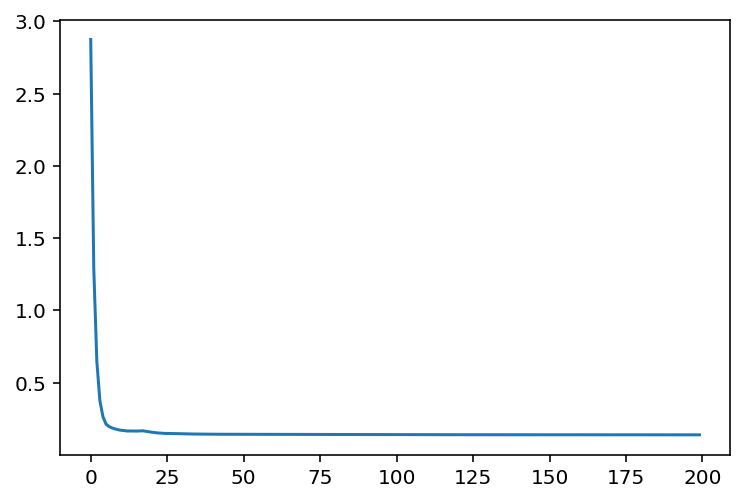

In [30]:
dalle_model_file = "data/rainbow_dalle.model"
if not os.path.exists(dalle_model_file):
    dalle, loss_history = fit(dalle, opt, None, scheduler, 
                              (captions_array[train_idx, ...], all_image_codes[train_idx, ...], captions_mask[train_idx, ...]), None, 200, 256, 
                              dalle_model_file, train_dalle_batch, 
                              n_train_samples=len(train_idx))

    plt.plot(loss_history)
else:
    dalle.load_state_dict(torch.load(dalle_model_file))

In [31]:
generated_images = []
with torch.no_grad():
    for i in trange(0, len(captions), 128):
        generated = dalle.generate_images(captions_array[i:i + 128, ...], mask=captions_mask[i:i + 128, ...], temperature=0.00001)
        generated_images.append(generated)

  0%|          | 0/72 [00:00<?, ?it/s]

In [32]:
generated_images = torch.cat(generated_images, axis=0).cpu().numpy()

## Generating images from descriptions in the training set
Top: original images

Bottom: images predicted by DALL-E based on their text descriptions (and reconstructed by VAE)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(-0.5, 319.5, 63.5, -0.5)

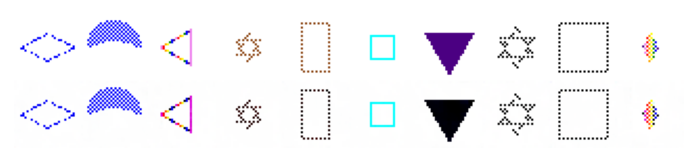

In [33]:
idx = np.random.choice(train_idx, 10)
orig_pics = images[idx, ...].cpu().permute(0, 2, 3, 1).reshape(320, 32, 3).permute(1, 0, 2).numpy()
decoded_pics = generated_images[idx, ...].transpose(0, 2, 3, 1).reshape(320, 32, 3).transpose(1, 0, 2)
both = np.concatenate((orig_pics, decoded_pics), axis=0)
plt.imshow(both)
plt.axis("off")

## Generating images from descriptions in the test set
These are predictions based on unseen text descriptions

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(-0.5, 319.5, 63.5, -0.5)

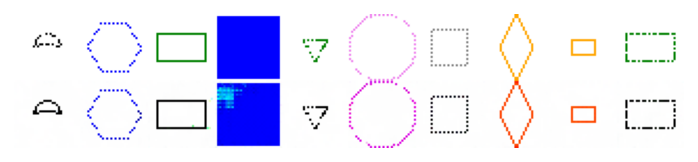

In [34]:
test_idx = np.ones(len(captions), bool)
test_idx[train_idx] = False
test_idx = np.flatnonzero(test_idx)
idx = np.random.choice(test_idx, 10)
orig_pics = images[idx, ...].cpu().permute(0, 2, 3, 1).reshape(320, 32, 3).permute(1, 0, 2).numpy()
decoded_pics = generated_images[idx, ...].transpose(0, 2, 3, 1).reshape(320, 32, 3).transpose(1, 0, 2)
both = np.concatenate((orig_pics, decoded_pics), axis=0)
plt.imshow(both)
plt.axis("off")

## Generating image tokens and checking token-based accuracy

In [35]:
from torch.nn import functional as F

def generate_image_code(dalle, text, mask):
    vae, text_seq_len, image_seq_len, num_text_tokens = dalle.vae, dalle.text_seq_len, dalle.image_seq_len, dalle.num_text_tokens
    total_len = text_seq_len + image_seq_len
    out = text

    for cur_len in range(text.shape[1], total_len):
        is_image = cur_len >= text_seq_len

        text, image = out[:, :text_seq_len], out[:, text_seq_len:]

        logits = dalle(text, image, mask = mask)[:, -1, :]
        chosen = torch.argmax(logits, dim=1, keepdim=True)
        chosen -= (num_text_tokens if is_image else 0) # offset sampled token if it is an image token, since logit space is composed of text and then image tokens
        out = torch.cat((out, chosen), dim=-1)

        if out.shape[1] <= text_seq_len:
            mask = F.pad(mask, (0, 1), value=True)

    img_seq = out[:, -image_seq_len:]
    return img_seq

In [44]:
generated_image_codes = []
with torch.no_grad():
    for i in trange(0, len(captions), 128):
        generated = generate_image_code(dalle, captions_array[i:i + 128, ...], mask=captions_mask[i:i + 128, ...])
        generated_image_codes.append(generated)
        
generated_image_codes = torch.cat(generated_image_codes, axis=0).cpu()

  0%|          | 0/72 [00:00<?, ?it/s]

In [42]:
# prevent OOM error and commence inference on CPU
torch.cuda.empty_cache()
vae.cpu()

DiscreteVAE(
  (codebook): Embedding(256, 512)
  (encoder): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): ReLU()
    )
    (1): Sequential(
      (0): Conv2d(64, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): ReLU()
    )
    (2): Sequential(
      (0): Conv2d(64, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): ReLU()
    )
    (3): ResBlock(
      (net): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU()
        (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (3): ReLU()
        (4): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
      )
    )
    (4): ResBlock(
      (net): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU()
        (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (3): ReLU()
  

In [45]:
with torch.no_grad():
    generated_images = vae.decode(generated_image_codes)

## Accuracy (of full token string equality) on the train set is 1
## On the test set, it is ~0.3
The errors are uniformly distributed across positions

Each position is predicted at >0.8 accuracy level

Train accuracy: 1.00, test accuracy: 0.49


Text(0.5, 0, 'position of image token')

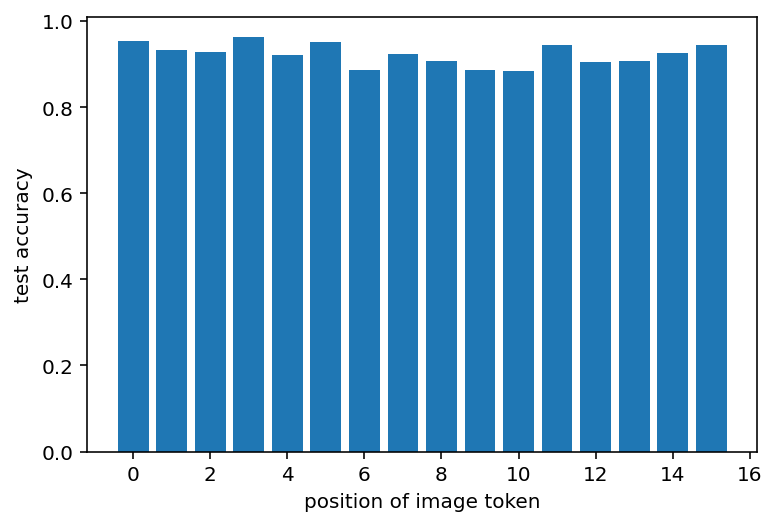

In [38]:
wrong_image_codes = (all_image_codes != generated_image_codes).sum(axis=1) != 0
print(f"Train accuracy: {1 - wrong_image_codes[train_idx].sum().item() / len(train_idx):.2f}, "
      f"test accuracy: {1 - wrong_image_codes[test_idx].sum().item() / len(test_idx):.2f}")

accuracy_by_position = 1 - ((all_image_codes != generated_image_codes).sum(axis=0) / len(test_idx)).cpu().numpy()
plt.bar(range(len(accuracy_by_position)), accuracy_by_position)
plt.ylabel("test accuracy")
plt.xlabel("position of image token")

## Examples of wrong predictions
Many wrong predictions are perceptually acceptable: often small deviations from ground truth

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(-0.5, 319.5, 63.5, -0.5)

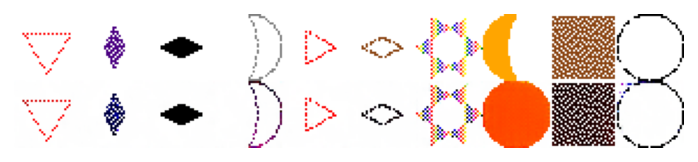

In [47]:
wrong_idx = np.flatnonzero((wrong_image_codes).cpu().numpy())
idx = np.random.choice(wrong_idx, 10)
orig_pics = images[idx, ...].cpu().permute(0, 2, 3, 1).reshape(320, 32, 3).permute(1, 0, 2).numpy()
decoded_pics = generated_images[idx, ...].cpu().permute(0, 2, 3, 1).reshape(320, 32, 3).permute(1, 0, 2).numpy()
both = np.concatenate((orig_pics, decoded_pics), axis=0)
plt.imshow(both)
plt.axis("off")